In [ ]:
# ===============================
# Convolutional Neural Network using Tensorflow using fit API
# Dataset: Cat and Dogs Recognition
# ===============================
from math import *
import matplotlib.pyplot as plt
import numpy as np
import h5py
from typing import List, Optional, Tuple
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from functools import partial
import optuna

In [15]:
def load_data(
    validation_ratio: float = 0.5,
    random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Load training and test data from HDF5 files and split test set into validation and final test sets

    Parameters
    validation_ratio : float, optional (default=0.5)
        Fraction of the original test set to use as validation data
    random_state : int, optional (default=42)
        Random seed for reproducibility

    Returns
    X_train : np.ndarray
        Training features
    y_train : np.ndarray
        Training labels
    X_val : np.ndarray
        Validation features
    y_val : np.ndarray
        Validation labels
    X_test : np.ndarray
        Test features
    y_test : np.ndarray
        Test labels
    """
    # Load training data
    with h5py.File("../cat_dog_datasets/trainset.hdf5", "r") as train_dataset:
        X_train = np.array(train_dataset["X_train"][:])
        y_train = np.array(train_dataset["Y_train"][:])

    # Load test data
    with h5py.File("../cat_dog_datasets/testset.hdf5", "r") as test_dataset:
        X_test_full = np.array(test_dataset["X_test"][:])
        y_test_full = np.array(test_dataset["Y_test"][:])

    # Split test data into validation and test sets
    X_val, X_test, y_val, y_test = train_test_split(
        X_test_full,
        y_test_full,
        test_size=validation_ratio,
        random_state=random_state,
        stratify=y_test_full if len(np.unique(y_test_full)) > 1 else None
    )

    return X_train, y_train, X_val, y_val, X_test, y_test

In [16]:
# Define human-readable label names
label_names = {0: "Cat", 1: "Dog"}

def plot_images(
    X: np.ndarray,
    y: np.ndarray,
    y_pred: Optional[np.ndarray] = None,
    num_images: int = 10,
    img_shape: Tuple[int, int, int] = (64, 64, 1)
):
    """
    Plot flattened/normalized images with true and predicted labels
    
    Parameters:
    X : np.ndarray
        Flattened images (N, features)
    y : np.ndarray
        true labels (N, num_classes)
    y_pred : np.ndarray, optional
        predicted labels (N, num_classes)
    num_images : int, optional (default=10)
        Number of images to plot
    img_shape : Tuple[int, int, int]
        Original image shape (H, W, C)

    Returns:
    """
    # Convert one-hot to integer labels if needed
    if y.ndim > 1:
        y_int = np.argmax(y, axis=1)
    else:
        y_int = y

    # Dynamically compute grid size
    n_cols = min(5, num_images)  # max 5 images per row
    n_rows = ceil(num_images / n_cols)

    plt.figure(figsize=(4*n_cols, 4*n_rows))
    
    for i in range(num_images):
        plt.subplot(n_rows, n_cols, i+1)
        
        # Reshape flattened image back to original shape
        img = X[i]
        # Handle grayscale (C=1) or color (C=3)
        if img.ndim == 3 and img.shape[-1] == 1:
            plt.imshow(img.squeeze(), cmap='gray')
        else:
            plt.imshow(np.clip(img, 0, 1))  # RGB image, ensure 0–1 range
        img = X[i].reshape(img_shape)
        
        # Title with True / Pred labels
        title = f"True: {label_names[y_int[i]]}"
        if y_pred is not None:
            title += f"\nPred: {label_names[y_pred[i]]}"
            
            # Optional: color title green/red for correct/incorrect
            color = 'green' if y_int[i] == y_pred[i] else 'red'
            plt.title(title, color=color, fontsize=10)
        else:
            plt.title(title, fontsize=10)
        
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

Data loaded:
X_train shape: (1000, 64, 64, 1), y_train shape: (1000, 1)


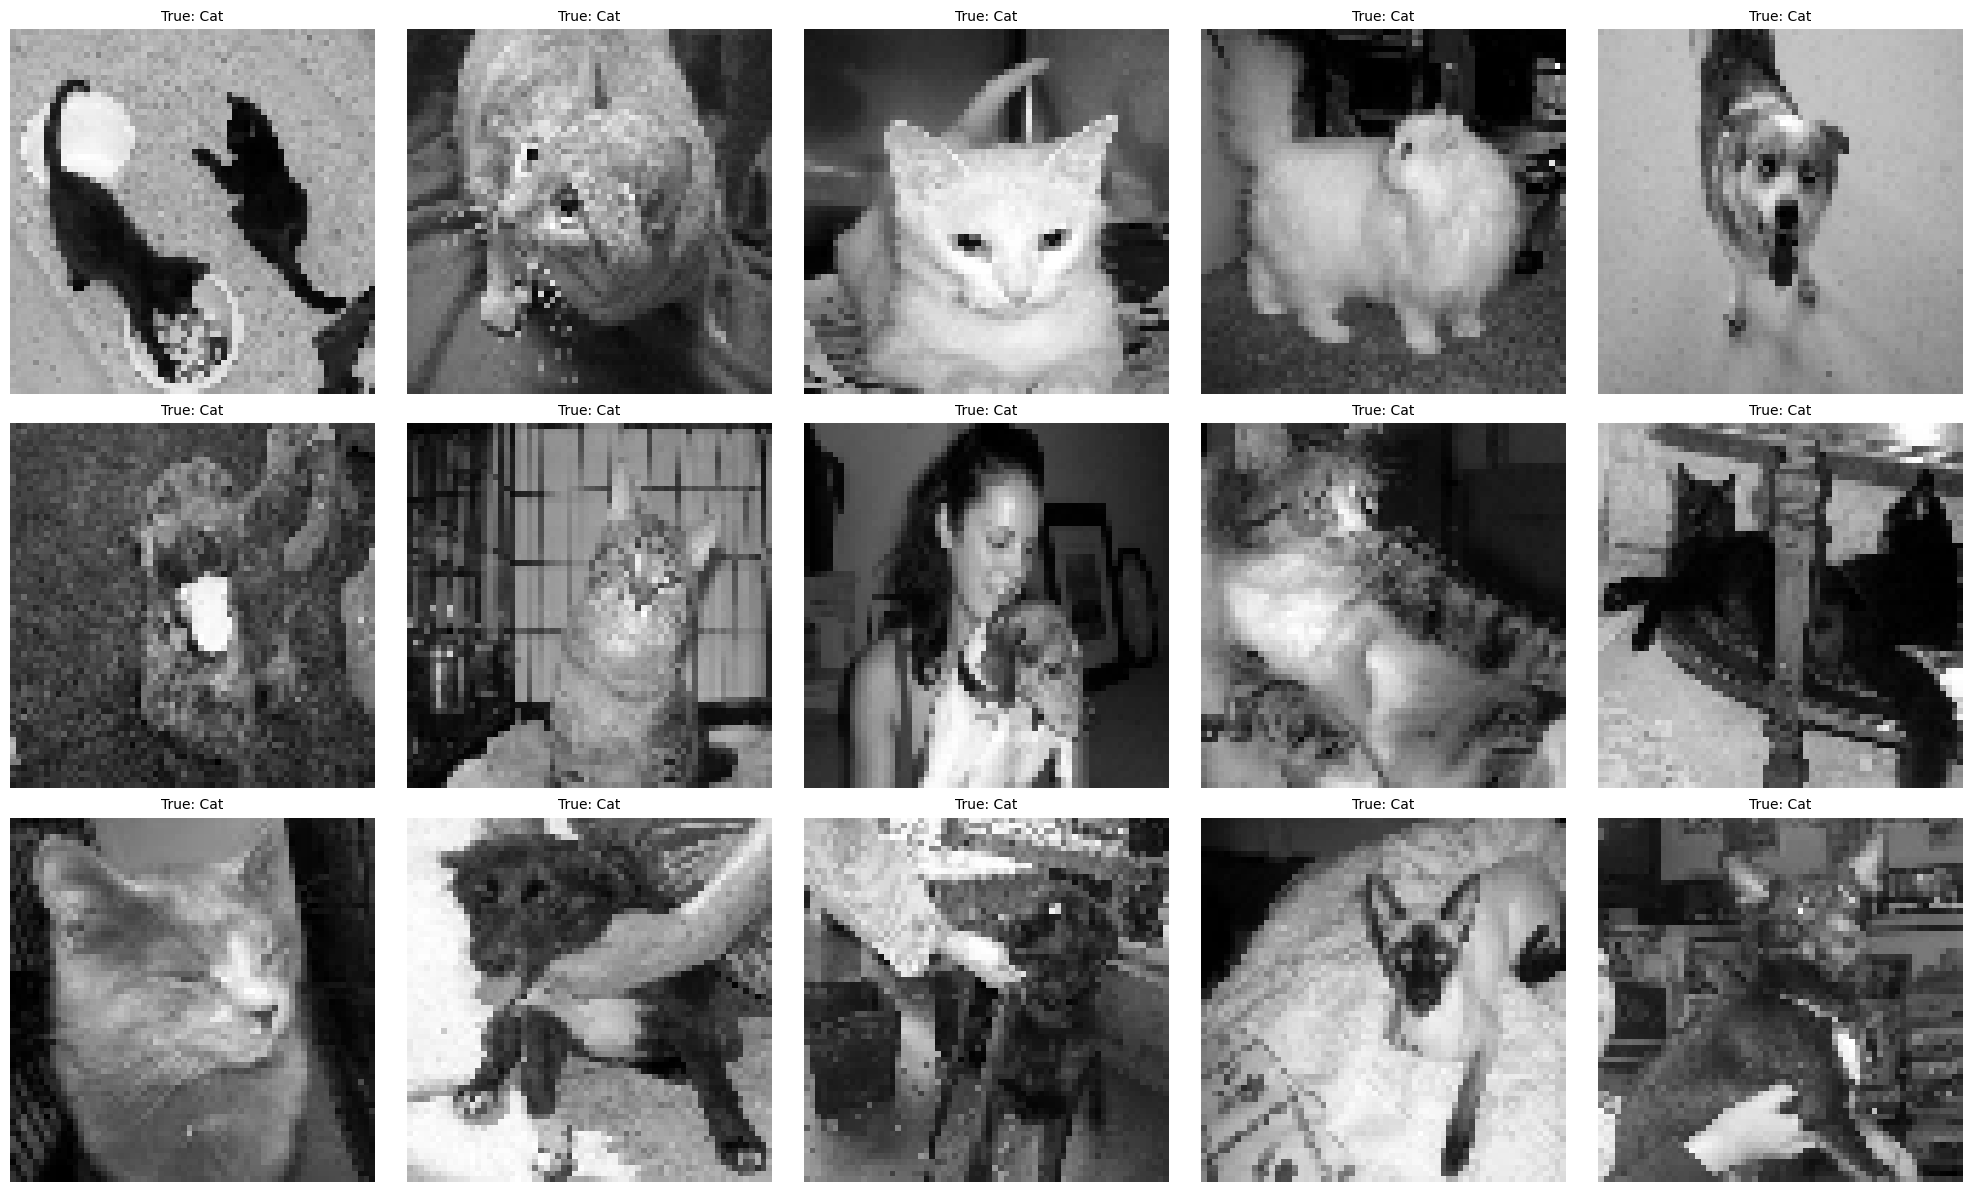

Preprocessing data...


/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/Users/tomcuel/.venvs/global_env/lib/python3.13/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [17]:
plot_image = True
augment_by_hand = False
# =======================================
# 1. Load and Preprocess Data
# =======================================
X_train, y_train, X_val, y_val, X_test, y_test = load_data()
# Grayscale images (1 channel)
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
X_test = X_test[..., np.newaxis]
print("Data loaded:")
if plot_image:
    print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    plot_images(X_train, y_train, num_images=15, img_shape=(64, 64, 1))

# Data Augmentation Function
def augment_image(
    image: tf.Tensor
) -> tf.Tensor:
    """
    Apply data augmentation to a single image tensor

    Parameters: 
    image : tf.Tensor
        Input image tensor of shape (H, W, C)
        
    Returns:
    tf.Tensor
        Augmented image tensor
    """
    image = tf.image.random_flip_left_right(image)
    image = tf.image.rot90(image, k=tf.random.uniform([], 0, 4, dtype=tf.int32))
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)
    
    crop_scale = tf.random.uniform([], 0.9, 1.0)
    crop_h = tf.cast(crop_scale * tf.cast(tf.shape(image)[0], tf.float32), tf.int32)
    crop_w = tf.cast(crop_scale * tf.cast(tf.shape(image)[1], tf.float32), tf.int32)
    image = tf.image.random_crop(image, size=[crop_h, crop_w, tf.shape(image)[-1]])
    image = tf.image.resize(image, (64, 64))
    
    return image

# Apply augmentation to the whole dataset
if augment_by_hand:
    X_train_aug = []
    for i in range(X_train.shape[0]):
        img = tf.convert_to_tensor(X_train[i], dtype=tf.float32)
        img_aug = augment_image(img)
        X_train_aug.append(img_aug.numpy())
    X_train = np.array(X_train_aug)
    print("Augmented images:")
    if plot_image:
        print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
        plot_images(X_train, y_train, num_images=15, img_shape=(64, 64, 1))

# Normalize
print("Preprocessing data...")
X_train = X_train.astype("float32") / 255.0
X_val = X_val.astype("float32") / 255.0
X_test = X_test.astype("float32") / 255.0

# Label Encoding
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_val = encoder.transform(y_val)
y_test = encoder.transform(y_test)

output_dim = int(len(np.unique(y_train)))

In [18]:
# =======================================
# RNG setup 
RNG_SEED = 42
np.random.seed(RNG_SEED)
tf.random.set_seed(RNG_SEED)

In [19]:
# =======================================
# 2. Tensor Creation
# =======================================
def df_to_tf_dataset(
    X: np.ndarray,
    y: np.ndarray,
    batch_size: int = 64,
    shuffle: bool = True,
    augment_fn: Optional[callable] = None
) -> tf.data.Dataset:
    """
    Create a TensorFlow Dataset for image data (CNN-ready)

    Parameters
    ----------
    X : np.ndarray
        Image array of shape (N, H, W, C)
    y : np.ndarray
        Label array (one-hot or integer)
    batch_size : int
        Batch size for the dataset (default=64)
    shuffle : bool
        Whether to shuffle the dataset (default=True)
    augment_fn : callable, optional
        Function for on-the-fly data augmentation (e.g., augment_image)

    Returns
    -------
    tf.data.Dataset
        Optimized TensorFlow dataset ready for training
    """
    # Convert to tensor
    X_tensor = tf.convert_to_tensor(X, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.int32)
    # Dataset from tuple (X, y)
    ds = tf.data.Dataset.from_tensor_slices((X_tensor, y_tensor))
    # Shuffle if required
    if shuffle:
        ds = ds.shuffle(buffer_size=len(X), seed=RNG_SEED)
    # Apply augmentation
    if augment_fn is not None:
        ds = ds.map(lambda x, y: (augment_fn(x), y), num_parallel_calls=tf.data.AUTOTUNE)
    return ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)

In [20]:
# =======================================
# 3. Activation function
# =======================================
_ACTIVATION_MAP = {
    "relu": lambda: tf.keras.layers.ReLU(),
    "sigmoid": lambda: tf.keras.layers.Activation("sigmoid"),
    "tanh": lambda: tf.keras.layers.Activation("tanh"),
    "leaky_relu": lambda: tf.keras.layers.LeakyReLU(negative_slope=0.01),
    "gelu": lambda: tf.keras.layers.Activation(tf.nn.gelu),
    "elu": lambda: tf.keras.layers.ELU(),
    "softmax_logit": None  # handled separately for logits
}

In [21]:
# =======================================
# 4. Dataclass for hyperparameters
# =======================================
@dataclass
class TrainConfig:
    conv_layers: List[Tuple[int, int]] = None
    dense_layers: list[int] = None
    activations: Optional[List[float]] = None
    dropout_rates: Optional[List[float]] = None
    loss_function: str = "cross_entropy"
    lr: float = 1e-3
    batch_size: int = 64
    epochs: int = 100
    weight_decay: float = 1e-5
    step_size: int = 20
    gamma: float = 0.5
    early_stopping: bool = True
    patience: int = 10
    clip_grad_norm: Optional[float] = 1.0
    use_amp: bool = True  # automatic mixed precision

In [22]:
# =======================================
# 5. Model Definition — CNN Version (2D & 3D)
# =======================================
class ConvNN(tf.keras.Model):
    def __init__(
        self,
        conv_layers: List[Tuple[int, int]], 
        dense_layers: List[int],
        output_dim: int,
        activations: Optional[List[str]] = None,
        dropout_rates: Optional[List[float]] = None,
        use_batchnorm: bool = True,
        use_pooling: bool = True
    ):
        """
        Configurable CNN supporting both grayscale (H,W,1) and RGB (H,W,3)

        Parameters:
        conv_layers : List[Tuple[int, int]]
            Each tuple defines (filters, kernel_size)
        dense_layers : List[int]
            Sizes of fully connected layers
        output_dim : int
            Number of output classes
        activations : List[str], optional
            Activation functions for dense layers
        dropout_rates : List[float], optional
            Dropout rates for dense layers
        use_batchnorm : bool
            Whether to apply batch normalization
        use_pooling : bool
            Whether to apply MaxPooling after convolutions
        """
        super().__init__()
        self.layers_list = []

        # Convolutional feature extractor
        for idx, (filters, ksize) in enumerate(conv_layers):
            self.layers_list.append(tf.keras.layers.Conv2D(
                filters=filters,
                kernel_size=ksize,
                padding="same",
                activation=None,
                kernel_initializer=tf.keras.initializers.HeNormal(),
                bias_initializer="zeros",
            ))
            if use_batchnorm:
                self.layers_list.append(tf.keras.layers.BatchNormalization())
            self.layers_list.append(tf.keras.layers.ReLU())
            if use_pooling:
                self.layers_list.append(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

        # Flatten before dense layers
        self.layers_list.append(tf.keras.layers.Flatten())

        # Fully connected classifier
        n_dense = len(dense_layers)
        if activations is None:
            activations = ["relu"] * n_dense
        if dropout_rates is None:
            dropout_rates = [0.0] * n_dense
        assert len(activations) == n_dense
        assert len(dropout_rates) == n_dense

        for idx, units in enumerate(dense_layers):
            act_name = activations[idx]
            act_ctor = _ACTIVATION_MAP.get(act_name)
            kernel_init = (tf.keras.initializers.HeNormal() if act_name in ("relu", "leaky_relu") else tf.keras.initializers.GlorotNormal())
            self.layers_list.append(tf.keras.layers.Dense(units, kernel_initializer=kernel_init, bias_initializer="zeros"))
            if use_batchnorm:
                self.layers_list.append(tf.keras.layers.BatchNormalization())
            if act_ctor is not None:
                self.layers_list.append(act_ctor() if callable(act_ctor) else act_ctor)
            if dropout_rates[idx] and dropout_rates[idx] > 0:
                self.layers_list.append(tf.keras.layers.Dropout(dropout_rates[idx]))

        # Output layer (no activation → logits)
        self.layers_list.append(tf.keras.layers.Dense(output_dim, kernel_initializer=tf.keras.initializers.GlorotNormal(), bias_initializer="zeros"))

    def call(
        self: tf.keras.Model,
        inputs: tf.Tensor,
        training: bool = False
    ) -> tf.Tensor:
        """
        Forward pass through the network

        Parameters:
        inputs : tf.Tensor
            Input tensor
        training : bool, optional
            Whether in training mode (for dropout, batchnorm)

        Returns:
        tf.Tensor
            Output logits tensor
        """
        x = inputs
        for layer in self.layers_list:
            if isinstance(layer, tf.keras.layers.Dropout):
                x = layer(x, training=training)
            else:
                x = layer(x)
        return x

In [23]:
# =======================================
# 6. Training Function
# =======================================
def train_model(
    X_train: np.ndarray,
    y_train: np.ndarray, 
    X_val: np.ndarray,
    y_val: np.ndarray,
    output_dim: int,
    config: TrainConfig,
    plot_loss: bool = False
) -> Tuple[tf.keras.Model, tf.keras.callbacks.History]:
    """
    Train the Convolutional Neural Network model

    Parameters:
    X_train : np.ndarray
        Training features
    y_train : np.ndarray
        Training labels
    X_val : np.ndarray
        Validation features
    y_val : np.ndarray
        Validation labels
    output_dim : int
        Number of output classes
    config : TrainConfig
        Training configuration parameters
    plot_loss : bool, optional
        Whether to plot training and validation loss curves

    Returns:
    model : tf.keras.Model
        Trained model
    history : tf.keras.callbacks.History
        Training history object
    """
    # Dataloaders
    train_dataset = df_to_tf_dataset(X_train, y_train, batch_size=config.batch_size, shuffle=True, augment_fn=augment_image if augment_by_hand==False else None)
    val_dataset = df_to_tf_dataset(X_val, y_val, batch_size=config.batch_size, shuffle=False)

    # AMP policy
    if config.use_amp:
        tf.keras.mixed_precision.set_global_policy("mixed_float16")

    # Model creation
    model = ConvNN(
            conv_layers=config.conv_layers,
            dense_layers=config.dense_layers, 
            output_dim=output_dim,
            activations=config.activations, 
            dropout_rates=config.dropout_rates, 
            use_batchnorm=True, 
            use_pooling=True
        )

    # Learning rate scheduler
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=config.lr,
        decay_steps=config.step_size * len(train_dataset),
        decay_rate=config.gamma,
        staircase=True,
    )

    # Optimizer
    optimizer = tf.keras.optimizers.AdamW(learning_rate=lr_schedule, weight_decay=config.weight_decay)

    # Compile model
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
    )

    # Callbacks (Early stopping + checkpoint)
    callbacks = []
    if config.early_stopping:
        callbacks.append(
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss", patience=config.patience,
                restore_best_weights=True, verbose=1,
            )
        )

    callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(
            filepath="best_model_cnn.weights.h5",
            monitor="val_loss",
            save_best_only=True, save_weights_only=True,
        )
    )

    # Train the model
    history = model.fit(
        train_dataset, validation_data=val_dataset,
        epochs=config.epochs,
        verbose=1,callbacks=callbacks,
    )

    # Plot losses
    if plot_loss:
        plt.figure(figsize=(6, 4))
        plt.plot(history.history["loss"], label="Train Loss")
        plt.plot(history.history["val_loss"], label="Val Loss")
        plt.legend()
        plt.title("Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    return model, history

In [24]:
# =======================================
# 7. Prediction & Evaluation
# =======================================
def predict_tf(
    model: tf.keras.Model,
    X: np.ndarray,
    y: np.ndarray, 
    batch_size: int = 64
) -> Tuple[np.ndarray, np.ndarray]: 
    """
    Predict classes and probabilities using the trained model

    Parameters:
    model : tf.keras.Model
        Trained model
    X : np.ndarray
        Input features
    y : np.ndarray
        True labels
    batch_size : int, optional
        Batch size for prediction  

    Returns:
    np.ndarray
        Predicted class labels
    np.ndarray
        Predicted class probabilities
    """
    ds = df_to_tf_dataset(X, y, batch_size=batch_size, shuffle=False) 
    probs_list = [] 
    for X_batch, _ in ds:
        logits = model(X_batch, training=False) 
        probs = tf.nn.softmax(logits) 
        probs_list.append(probs) 
    probs = tf.concat(probs_list, axis=0) 
    preds = tf.argmax(probs, axis=1).numpy()
    return preds, probs.numpy()

def accuracy_score(
    y_true: np.ndarray,
    y_pred: np.ndarray
) -> float:
    """
    Compute accuracy score between true and predicted labels

    Parameters:
    y_true : np.ndarray
        True labels
    y_pred : np.ndarray
        Predicted labels

    Returns:
    float
        Accuracy percentage
    """
    return np.mean(y_true == y_pred) * 100

In [ ]:
# =======================================
# 8. Hyperparameter Optimization with Optuna
# =======================================
def objective(
    trial: optuna.trial.Trial,
    loss_function: str = "cross_entropy",
    epochs: int = 40
) -> float:
    """
    Objective function for Optuna hyperparameter optimization

    Parameters:
    trial : optuna.trial.Trial
        Optuna trial object
    loss_function : str, optional
        Loss function to use
    epochs : int, optional
        Number of training epochs
    Returns:
    float
        Validation loss to minimize
    """
    # Number of convolutional layers
    n_conv_layers = trial.suggest_int("n_conv_layers", 2, 4)
    conv_layers = []
    for i in range(n_conv_layers):
        filters = trial.suggest_int(f"conv_filters_l{i}", 32, 128, step=32)
        kernel_size = trial.suggest_categorical(f"conv_kernel_size_l{i}", [3, 5])
        conv_layers.append((filters, kernel_size))

    # Number of dense layers
    n_dense_layers = trial.suggest_int("n_dense_layers", 1,2)
    dense_layers = []
    for i in range(n_dense_layers):
        dense_layers.append(trial.suggest_int(f"n_units_l{i}", 128, 512))
        
    # Common activation (keeps optimization stable)
    # activation = trial.suggest_categorical("activation", ["relu", "leaky_relu", "tanh"])
    # activations = [activation] * n_dense_layers
    # possible_activations = ["relu", "tanh", "leaky_relu"]
    # activations = [trial.suggest_categorical(f"activation_l{i}", possible_activations) for i in range(n_dense_layers)]

    # Regularization
    dropout_rates = [trial.suggest_float(f"dropout_l{i}", 0.1, 0.4) for i in range(n_dense_layers)]
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # Optimizer params
    lr = trial.suggest_float("lr", 1e-5, 5e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [8, 16, 32])
    step_size = trial.suggest_float("step_size", 5, 20)
    gamma = trial.suggest_float("gamma", 0.7, 0.99, log=True)

    # Early stopping
    stopping_patience = trial.suggest_int("stopping_patience", 5, 15)

    config = TrainConfig(
        conv_layers=conv_layers, 
        dense_layers=dense_layers,
        activations=None, 
        dropout_rates=dropout_rates, 
        loss_function=loss_function, 
        lr=lr, 
        batch_size=batch_size, 
        epochs=epochs, 
        weight_decay=weight_decay, 
        step_size=step_size, 
        gamma=gamma,
        early_stopping=True, 
        patience=stopping_patience, 
        use_amp=True
    )

    model, _ = train_model(
        X_train, 
        y_train, 
        X_val,
        y_val,
        output_dim,
        config,
        plot_loss=False
    )

    # Validation loss
    val_dataset = df_to_tf_dataset(X_val, y_val, batch_size=config.batch_size)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    val_loss_metric = tf.keras.metrics.Mean()
    for X_batch, y_batch in val_dataset:
        logits = model(X_batch, training=False)
        val_loss_metric.update_state(loss_fn(y_batch, logits))

    return val_loss_metric.result().numpy()

# Run Optuna study
loss_function = "cross_entropy"
epochs = 20
obj = partial(objective, loss_function=loss_function, epochs=epochs)
study = optuna.create_study(direction="minimize", pruner=optuna.pruners.MedianPruner())
study.optimize(obj, n_trials=20)

# Best result summary
print("Best trial:")
trial = study.best_trial
print(f"  Value: {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-11-01 13:18:53,886] A new study created in memory with name: no-name-e3f0a58c-5d3c-462e-bb51-fdde8aa3531b


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.8690 - sparse_categorical_accuracy: 0.5165 - val_loss: 0.6830 - val_sparse_categorical_accuracy: 0.5900
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 65ms/step - loss: 0.8117 - sparse_categorical_accuracy: 0.5253 - val_loss: 0.7434 - val_sparse_categorical_accuracy: 0.5100
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.8218 - sparse_categorical_accuracy: 0.5189 - val_loss: 0.8084 - val_sparse_categorical_accuracy: 0.5400
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.7608 - sparse_categorical_accuracy: 0.5428 - val_loss: 0.8216 - val_sparse_categorical_accuracy: 0.4800
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.7544 - sparse_categorical_accuracy: 0.5839 - val_loss: 0.7412 - val_sparse_categorical_accuracy: 0.5400
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - loss: 0.7409 - sparse_categorical_accuracy: 0.5935 - val_loss: 0.7233 - val_sparse_categorical_accuracy: 0.6200
Epoch 7/20

[I 2025-11-01 13:19:53,636] Trial 0 finished with value: 0.678006649017334 and parameters: {'n_conv_layers': 3, 'conv_filters_l0': 64, 'conv_kernel_size_l0': 5, 'conv_filters_l1': 64, 'conv_kernel_size_l1': 5, 'conv_filters_l2': 64, 'conv_kernel_size_l2': 3, 'n_dense_layers': 1, 'n_units_l0': 224, 'dropout_l0': 0.16328733842214527, 'weight_decay': 3.7722944548126793e-06, 'lr': 1.8526434324473994e-05, 'batch_size': 16, 'step_size': 11.452374126494508, 'gamma': 0.9461440867924461, 'stopping_patience': 11}. Best is trial 0 with value: 0.678006649017334.


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step - loss: 1.4855 - sparse_categorical_accuracy: 0.5268 - val_loss: 0.7816 - val_sparse_categorical_accuracy: 0.5800
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.7849 - sparse_categorical_accuracy: 0.5814 - val_loss: 0.8251 - val_sparse_categorical_accuracy: 0.4700
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - loss: 0.7248 - sparse_categorical_accuracy: 0.5904 - val_loss: 0.8823 - val_sparse_categorical_accuracy: 0.5000
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - loss: 0.7399 - sparse_categorical_accuracy: 0.6074 - val_loss: 0.9162 - val_sparse_categorical_accuracy: 0.4900
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.7555 - sparse_categorical_accuracy: 0.5787 - val_loss: 0.8501 - val_sparse_categorical_accuracy: 0.5000
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - loss: 0.7317 - sparse_categorical_accuracy: 0.6016 - val_loss: 0.8332 - val_sparse_categorical_accuracy: 0.5100
Epoch 

[I 2025-11-01 13:21:02,263] Trial 1 finished with value: 0.6145842671394348 and parameters: {'n_conv_layers': 2, 'conv_filters_l0': 32, 'conv_kernel_size_l0': 3, 'conv_filters_l1': 96, 'conv_kernel_size_l1': 3, 'n_dense_layers': 1, 'n_units_l0': 401, 'dropout_l0': 0.3083909480962264, 'weight_decay': 0.00026070518830644695, 'lr': 0.0007000008260142288, 'batch_size': 32, 'step_size': 6.52606348795058, 'gamma': 0.7850487026242386, 'stopping_patience': 9}. Best is trial 1 with value: 0.6145842671394348.


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step - loss: 0.9245 - sparse_categorical_accuracy: 0.4963 - val_loss: 0.6978 - val_sparse_categorical_accuracy: 0.5400
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.8606 - sparse_categorical_accuracy: 0.4686 - val_loss: 0.7081 - val_sparse_categorical_accuracy: 0.5500
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.8065 - sparse_categorical_accuracy: 0.5227 - val_loss: 0.6846 - val_sparse_categorical_accuracy: 0.5900
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.8267 - sparse_categorical_accuracy: 0.5090 - val_loss: 0.6951 - val_sparse_categorical_accuracy: 0.6000
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 85ms/step - loss: 0.7797 - sparse_categorical_accuracy: 0.5276 - val_loss: 0.6969 - val_sparse_categorical_accuracy: 0.6000
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.7796 - sparse_categorical_accuracy: 0.5644 - val_loss: 0.7205 - val_sparse_categorical_accuracy: 0.5700
Epoch 7/20

2025-11-01 13:22:14.456131: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[I 2025-11-01 13:22:14,460] Trial 2 finished with value: 0.6780515313148499 and parameters: {'n_conv_layers': 4, 'conv_filters_l0': 128, 'conv_kernel_size_l0': 5, 'conv_filters_l1': 32, 'conv_kernel_size_l1': 3, 'conv_filters_l2': 32, 'conv_kernel_size_l2': 3, 'conv_filters_l3': 96, 'conv_kernel_size_l3': 3, 'n_dense_layers': 2, 'n_units_l0': 130, 'n_units_l1': 438, 'dropout_l0': 0.2568702778042327, 'dropout_l1': 0.2156295637914023, 'weight_decay': 1.2308171572219322e-05, 'lr': 8.187019850978348e-05, 'batch_size': 16, 'step_size': 16.916309733218778, 'gamma': 0.8005925260942699, 'stopping_patience': 10}. Best is trial 1 with value: 0.6145842671394348.


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 77ms/step - loss: 1.0262 - sparse_categorical_accuracy: 0.5351 - val_loss: 1.0100 - val_sparse_categorical_accuracy: 0.5100
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - loss: 0.7719 - sparse_categorical_accuracy: 0.4997 - val_loss: 0.9479 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 0.7793 - sparse_categorical_accuracy: 0.5320 - val_loss: 0.7605 - val_sparse_categorical_accuracy: 0.5100
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 93ms/step - loss: 0.7500 - sparse_categorical_accuracy: 0.5208 - val_loss: 0.7930 - val_sparse_categorical_accuracy: 0.5300
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 80ms/step - loss: 0.7291 - sparse_categorical_accuracy: 0.5307 - val_loss: 0.8019 - val_sparse_categorical_accuracy: 0.5400
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 77ms/step - loss: 0.7044 - sparse_categorical_accuracy: 0.5919 - val_loss: 0.7173 - val_sparse_categorical_accuracy:

[I 2025-11-01 13:25:33,716] Trial 3 finished with value: 0.651803731918335 and parameters: {'n_conv_layers': 2, 'conv_filters_l0': 96, 'conv_kernel_size_l0': 3, 'conv_filters_l1': 96, 'conv_kernel_size_l1': 3, 'n_dense_layers': 2, 'n_units_l0': 379, 'n_units_l1': 313, 'dropout_l0': 0.10099633546983824, 'dropout_l1': 0.2595151971628225, 'weight_decay': 0.0004588371000001735, 'lr': 0.004235913430330506, 'batch_size': 8, 'step_size': 16.94435237305779, 'gamma': 0.9632047346749362, 'stopping_patience': 14}. Best is trial 1 with value: 0.6145842671394348.


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1.0025 - sparse_categorical_accuracy: 0.5403 - val_loss: 0.7453 - val_sparse_categorical_accuracy: 0.5600
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.7584 - sparse_categorical_accuracy: 0.5305 - val_loss: 0.7112 - val_sparse_categorical_accuracy: 0.5400
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.7071 - sparse_categorical_accuracy: 0.5534 - val_loss: 0.7663 - val_sparse_categorical_accuracy: 0.4300
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.6771 - sparse_categorical_accuracy: 0.5907 - val_loss: 0.8369 - val_sparse_categorical_accuracy: 0.4300
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.6935 - sparse_categorical_accuracy: 0.5810 - val_loss: 0.7220 - val_sparse_categorical_accuracy: 0.5700
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 0.6651 - sparse_categorical_accuracy: 0.6242 - val_loss: 0.7809 - val_sparse_categorical_accuracy: 0.580

[I 2025-11-01 13:25:54,050] Trial 4 finished with value: 0.7105010151863098 and parameters: {'n_conv_layers': 2, 'conv_filters_l0': 64, 'conv_kernel_size_l0': 5, 'conv_filters_l1': 32, 'conv_kernel_size_l1': 3, 'n_dense_layers': 1, 'n_units_l0': 130, 'dropout_l0': 0.2898546877502445, 'weight_decay': 1.3399367525378561e-05, 'lr': 0.0032470319667019898, 'batch_size': 8, 'step_size': 10.976583453375534, 'gamma': 0.889072129222372, 'stopping_patience': 5}. Best is trial 1 with value: 0.6145842671394348.


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 47ms/step - loss: 0.8561 - sparse_categorical_accuracy: 0.4737 - val_loss: 0.7903 - val_sparse_categorical_accuracy: 0.4800
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.7898 - sparse_categorical_accuracy: 0.5412 - val_loss: 0.7640 - val_sparse_categorical_accuracy: 0.4900
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.7716 - sparse_categorical_accuracy: 0.5639 - val_loss: 0.7133 - val_sparse_categorical_accuracy: 0.5800
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.8119 - sparse_categorical_accuracy: 0.5521 - val_loss: 0.7972 - val_sparse_categorical_accuracy: 0.5600
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - loss: 0.7547 - sparse_categorical_accuracy: 0.5821 - val_loss: 0.7038 - val_sparse_categorical_accuracy: 0.6300
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 0.7573 - sparse_categorical_accuracy: 0.5910 - val_loss: 0.8135 - val_sparse_categorical_accuracy: 0.620

[I 2025-11-01 13:27:24,027] Trial 5 finished with value: 0.6363207101821899 and parameters: {'n_conv_layers': 3, 'conv_filters_l0': 128, 'conv_kernel_size_l0': 3, 'conv_filters_l1': 96, 'conv_kernel_size_l1': 3, 'conv_filters_l2': 32, 'conv_kernel_size_l2': 5, 'n_dense_layers': 1, 'n_units_l0': 161, 'dropout_l0': 0.29010644868000296, 'weight_decay': 0.00012342886248801907, 'lr': 5.739321701926459e-05, 'batch_size': 8, 'step_size': 7.660210400518471, 'gamma': 0.8355268547434613, 'stopping_patience': 5}. Best is trial 1 with value: 0.6145842671394348.


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 61ms/step - loss: 1.0921 - sparse_categorical_accuracy: 0.5173 - val_loss: 0.9238 - val_sparse_categorical_accuracy: 0.5600
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.8596 - sparse_categorical_accuracy: 0.4727 - val_loss: 0.7794 - val_sparse_categorical_accuracy: 0.5400
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.7715 - sparse_categorical_accuracy: 0.5317 - val_loss: 0.7059 - val_sparse_categorical_accuracy: 0.5900
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 60ms/step - loss: 0.7624 - sparse_categorical_accuracy: 0.5337 - val_loss: 0.9077 - val_sparse_categorical_accuracy: 0.5100
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 0.7456 - sparse_categorical_accuracy: 0.5743 - val_loss: 0.6888 - val_sparse_categorical_accuracy: 0.5600
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 59ms/step - loss: 0.7282 - sparse_categorical_accuracy: 0.6022 - val_loss: 1.2507 - val_sparse_categorical_accuracy: 0.48

[I 2025-11-01 13:29:57,631] Trial 6 finished with value: 0.6444462537765503 and parameters: {'n_conv_layers': 3, 'conv_filters_l0': 96, 'conv_kernel_size_l0': 3, 'conv_filters_l1': 96, 'conv_kernel_size_l1': 5, 'conv_filters_l2': 96, 'conv_kernel_size_l2': 3, 'n_dense_layers': 2, 'n_units_l0': 394, 'n_units_l1': 348, 'dropout_l0': 0.18885352045239873, 'dropout_l1': 0.37718936877829434, 'weight_decay': 5.694142880489454e-06, 'lr': 0.0035654033350084164, 'batch_size': 8, 'step_size': 13.723768501381338, 'gamma': 0.8149774176072628, 'stopping_patience': 15}. Best is trial 1 with value: 0.6145842671394348.


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 207ms/step - loss: 1.5839 - sparse_categorical_accuracy: 0.5314 - val_loss: 1.1866 - val_sparse_categorical_accuracy: 0.5100
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - loss: 0.7453 - sparse_categorical_accuracy: 0.5422 - val_loss: 0.7275 - val_sparse_categorical_accuracy: 0.5900
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - loss: 0.7481 - sparse_categorical_accuracy: 0.5754 - val_loss: 0.8168 - val_sparse_categorical_accuracy: 0.5200
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 193ms/step - loss: 0.6968 - sparse_categorical_accuracy: 0.6028 - val_loss: 0.7891 - val_sparse_categorical_accuracy: 0.4600
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - loss: 0.7199 - sparse_categorical_accuracy: 0.5616 - val_loss: 0.8851 - val_sparse_categorical_accuracy: 0.4800
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 194ms/step - loss: 0.7266 - sparse_categorical_accuracy: 0.5726 - val_loss: 0.7364 - val_sparse_categorical_accuracy: 0.5000
Epoc

[I 2025-11-01 13:31:15,348] Trial 7 finished with value: 0.7290924191474915 and parameters: {'n_conv_layers': 2, 'conv_filters_l0': 96, 'conv_kernel_size_l0': 5, 'conv_filters_l1': 64, 'conv_kernel_size_l1': 5, 'n_dense_layers': 1, 'n_units_l0': 510, 'dropout_l0': 0.15169002927194594, 'weight_decay': 0.000756298095439444, 'lr': 0.001041002935384442, 'batch_size': 32, 'step_size': 12.485290217424375, 'gamma': 0.7795727556547736, 'stopping_patience': 10}. Best is trial 1 with value: 0.6145842671394348.


Epoch 1/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 10s 136ms/step - loss: 1.1299 - sparse_categorical_accuracy: 0.5601 - val_loss: 0.8678 - val_sparse_categorical_accuracy: 0.5800
Epoch 2/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 0.8670 - sparse_categorical_accuracy: 0.5353 - val_loss: 1.6569 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - loss: 0.7725 - sparse_categorical_accuracy: 0.5792 - val_loss: 0.8590 - val_sparse_categorical_accuracy: 0.5400
Epoch 4/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - loss: 0.7480 - sparse_categorical_accuracy: 0.5667 - val_loss: 0.7585 - val_sparse_categorical_accuracy: 0.5400
Epoch 5/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 9s 143ms/step - loss: 0.8006 - sparse_categorical_accuracy: 0.5690 - val_loss: 0.6891 - val_sparse_categorical_accuracy: 0.6700
Epoch 6/20
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 131ms/step - loss: 0.7028 - sparse_categorical_accuracy: 0.6081 - val_loss: 0.8510 - val_sparse_categorical_accuracy: 0.6100
Epo

[I 2025-11-01 13:34:12,148] Trial 8 finished with value: 0.6676289439201355 and parameters: {'n_conv_layers': 2, 'conv_filters_l0': 128, 'conv_kernel_size_l0': 5, 'conv_filters_l1': 64, 'conv_kernel_size_l1': 5, 'n_dense_layers': 1, 'n_units_l0': 380, 'dropout_l0': 0.28537253262476975, 'weight_decay': 1.1310426006039775e-06, 'lr': 0.0002376791849686732, 'batch_size': 16, 'step_size': 6.324015602011225, 'gamma': 0.8217620682973321, 'stopping_patience': 14}. Best is trial 1 with value: 0.6145842671394348.


Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.9435 - sparse_categorical_accuracy: 0.5383 - val_loss: 0.7293 - val_sparse_categorical_accuracy: 0.5400
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7472 - sparse_categorical_accuracy: 0.5217 - val_loss: 0.7257 - val_sparse_categorical_accuracy: 0.5500
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7043 - sparse_categorical_accuracy: 0.5838 - val_loss: 0.6866 - val_sparse_categorical_accuracy: 0.5800
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.6961 - sparse_categorical_accuracy: 0.5617 - val_loss: 0.8271 - val_sparse_categorical_accuracy: 0.5700
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.7096 - sparse_categorical_accuracy: 0.5731 - val_loss: 0.7245 - val_sparse_categorical_accuracy: 0.5800
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.6757 - sparse_categorical_accuracy: 0.6137 - val_loss: 0.7753 - val_sparse_categorical_accuracy: 0.560

[I 2025-11-01 13:35:12,601] Trial 9 finished with value: 0.634219229221344 and parameters: {'n_conv_layers': 3, 'conv_filters_l0': 32, 'conv_kernel_size_l0': 3, 'conv_filters_l1': 128, 'conv_kernel_size_l1': 3, 'conv_filters_l2': 32, 'conv_kernel_size_l2': 5, 'n_dense_layers': 1, 'n_units_l0': 202, 'dropout_l0': 0.12396713130105791, 'weight_decay': 1.2710339707992051e-05, 'lr': 0.0025713335735953044, 'batch_size': 8, 'step_size': 10.221708368629194, 'gamma': 0.7633537987937806, 'stopping_patience': 12}. Best is trial 1 with value: 0.6145842671394348.


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 127ms/step - loss: 0.7691 - sparse_categorical_accuracy: 0.5836 - val_loss: 1.4383 - val_sparse_categorical_accuracy: 0.5100
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - loss: 0.7909 - sparse_categorical_accuracy: 0.5340 - val_loss: 0.8176 - val_sparse_categorical_accuracy: 0.5500
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - loss: 0.7320 - sparse_categorical_accuracy: 0.5835 - val_loss: 0.9037 - val_sparse_categorical_accuracy: 0.5100
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 123ms/step - loss: 0.7443 - sparse_categorical_accuracy: 0.5638 - val_loss: 0.8390 - val_sparse_categorical_accuracy: 0.4400
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.6890 - sparse_categorical_accuracy: 0.6090 - val_loss: 0.7313 - val_sparse_categorical_accuracy: 0.6000
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 125ms/step - loss: 0.7090 - sparse_categorical_accuracy: 0.5999 - val_loss: 0.6658 - val_sparse_categorical_accuracy: 0.6700
Epoc

2025-11-01 13:36:11.979088: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
[I 2025-11-01 13:36:11,980] Trial 10 finished with value: 0.6374585628509521 and parameters: {'n_conv_layers': 4, 'conv_filters_l0': 32, 'conv_kernel_size_l0': 3, 'conv_filters_l1': 128, 'conv_kernel_size_l1': 3, 'conv_filters_l2': 128, 'conv_kernel_size_l2': 5, 'conv_filters_l3': 32, 'conv_kernel_size_l3': 5, 'n_dense_layers': 2, 'n_units_l0': 487, 'n_units_l1': 141, 'dropout_l0': 0.38707976904479413, 'dropout_l1': 0.11929992502842329, 'weight_decay': 9.953004765204254e-05, 'lr': 0.0005127728721157487, 'batch_size': 32, 'step_size': 5.153899374322913, 'gamma': 0.7040768859973848, 'stopping_patience': 8}. Best is trial 1 with value: 0.6145842671394348.


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 98ms/step - loss: 1.1399 - sparse_categorical_accuracy: 0.5289 - val_loss: 1.1564 - val_sparse_categorical_accuracy: 0.5100
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.8017 - sparse_categorical_accuracy: 0.5401 - val_loss: 0.9653 - val_sparse_categorical_accuracy: 0.5100
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.7793 - sparse_categorical_accuracy: 0.5709 - val_loss: 0.8180 - val_sparse_categorical_accuracy: 0.5200
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.7746 - sparse_categorical_accuracy: 0.5361 - val_loss: 0.8037 - val_sparse_categorical_accuracy: 0.5100
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.7353 - sparse_categorical_accuracy: 0.5637 - val_loss: 0.6770 - val_sparse_categorical_accuracy: 0.6200
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.7887 - sparse_categorical_accuracy: 0.5675 - val_loss: 0.7677 - val_sparse_categorical_accuracy: 0.4700
Epoch 7

[I 2025-11-01 13:37:17,990] Trial 11 finished with value: 0.6434230208396912 and parameters: {'n_conv_layers': 3, 'conv_filters_l0': 32, 'conv_kernel_size_l0': 3, 'conv_filters_l1': 128, 'conv_kernel_size_l1': 3, 'conv_filters_l2': 64, 'conv_kernel_size_l2': 5, 'n_dense_layers': 1, 'n_units_l0': 264, 'dropout_l0': 0.3560929646359105, 'weight_decay': 4.9135995641662076e-05, 'lr': 0.001048203019929419, 'batch_size': 32, 'step_size': 8.740054904709556, 'gamma': 0.7358101450431686, 'stopping_patience': 12}. Best is trial 1 with value: 0.6145842671394348.


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 110ms/step - loss: 1.0140 - sparse_categorical_accuracy: 0.5407 - val_loss: 1.2543 - val_sparse_categorical_accuracy: 0.5300
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.7455 - sparse_categorical_accuracy: 0.5762 - val_loss: 1.6036 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.7460 - sparse_categorical_accuracy: 0.5720 - val_loss: 0.8274 - val_sparse_categorical_accuracy: 0.4700
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 0.6835 - sparse_categorical_accuracy: 0.6096 - val_loss: 0.7475 - val_sparse_categorical_accuracy: 0.5400
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - loss: 0.7255 - sparse_categorical_accuracy: 0.5827 - val_loss: 0.6971 - val_sparse_categorical_accuracy: 0.5700
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 90ms/step - loss: 0.6970 - sparse_categorical_accuracy: 0.5950 - val_loss: 0.7336 - val_sparse_categorical_accuracy: 0.5300
Epoch 7/

[I 2025-11-01 13:38:22,873] Trial 12 finished with value: 0.607744038105011 and parameters: {'n_conv_layers': 4, 'conv_filters_l0': 32, 'conv_kernel_size_l0': 3, 'conv_filters_l1': 128, 'conv_kernel_size_l1': 3, 'conv_filters_l2': 32, 'conv_kernel_size_l2': 5, 'conv_filters_l3': 128, 'conv_kernel_size_l3': 5, 'n_dense_layers': 1, 'n_units_l0': 304, 'dropout_l0': 0.22209253104822807, 'weight_decay': 0.00019633072319718943, 'lr': 0.001012026986028455, 'batch_size': 32, 'step_size': 9.051612890572297, 'gamma': 0.7604525345037425, 'stopping_patience': 8}. Best is trial 12 with value: 0.607744038105011.


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - loss: 0.8563 - sparse_categorical_accuracy: 0.5599 - val_loss: 0.7795 - val_sparse_categorical_accuracy: 0.5900
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step - loss: 0.8588 - sparse_categorical_accuracy: 0.5587 - val_loss: 0.8205 - val_sparse_categorical_accuracy: 0.5600
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 0.7326 - sparse_categorical_accuracy: 0.6003 - val_loss: 0.7592 - val_sparse_categorical_accuracy: 0.5600
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 0.7348 - sparse_categorical_accuracy: 0.5847 - val_loss: 0.8879 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 153ms/step - loss: 0.7070 - sparse_categorical_accuracy: 0.6219 - val_loss: 0.7438 - val_sparse_categorical_accuracy: 0.5800
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - loss: 0.7204 - sparse_categorical_accuracy: 0.5821 - val_loss: 0.7481 - val_sparse_categorical_accuracy: 0.6000
Epoc

[I 2025-11-01 13:40:02,561] Trial 13 finished with value: 0.6099185347557068 and parameters: {'n_conv_layers': 4, 'conv_filters_l0': 64, 'conv_kernel_size_l0': 3, 'conv_filters_l1': 128, 'conv_kernel_size_l1': 3, 'conv_filters_l2': 96, 'conv_kernel_size_l2': 5, 'conv_filters_l3': 128, 'conv_kernel_size_l3': 5, 'n_dense_layers': 1, 'n_units_l0': 314, 'dropout_l0': 0.20807268434235363, 'weight_decay': 0.0002992173479477868, 'lr': 0.000360012284978497, 'batch_size': 32, 'step_size': 8.371252257852412, 'gamma': 0.7409862414557655, 'stopping_patience': 8}. Best is trial 12 with value: 0.607744038105011.


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 159ms/step - loss: 0.8220 - sparse_categorical_accuracy: 0.5535 - val_loss: 0.7590 - val_sparse_categorical_accuracy: 0.5000
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - loss: 0.8049 - sparse_categorical_accuracy: 0.5701 - val_loss: 0.6940 - val_sparse_categorical_accuracy: 0.5600
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 174ms/step - loss: 0.7428 - sparse_categorical_accuracy: 0.6013 - val_loss: 0.7118 - val_sparse_categorical_accuracy: 0.5600
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 171ms/step - loss: 0.7312 - sparse_categorical_accuracy: 0.6054 - val_loss: 0.7235 - val_sparse_categorical_accuracy: 0.5900
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 177ms/step - loss: 0.7284 - sparse_categorical_accuracy: 0.5905 - val_loss: 0.6991 - val_sparse_categorical_accuracy: 0.6000
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 0.6926 - sparse_categorical_accuracy: 0.5961 - val_loss: 0.7964 - val_sparse_categorical_accuracy: 0.5500
Epoc

[I 2025-11-01 13:40:52,794] Trial 14 finished with value: 0.6713695526123047 and parameters: {'n_conv_layers': 4, 'conv_filters_l0': 64, 'conv_kernel_size_l0': 3, 'conv_filters_l1': 128, 'conv_kernel_size_l1': 3, 'conv_filters_l2': 96, 'conv_kernel_size_l2': 5, 'conv_filters_l3': 128, 'conv_kernel_size_l3': 5, 'n_dense_layers': 1, 'n_units_l0': 303, 'dropout_l0': 0.2132916482848491, 'weight_decay': 0.00020851858306393907, 'lr': 0.00025006060268221596, 'batch_size': 32, 'step_size': 14.409919459493278, 'gamma': 0.729424015085326, 'stopping_patience': 7}. Best is trial 12 with value: 0.607744038105011.


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 0.8598 - sparse_categorical_accuracy: 0.5514 - val_loss: 0.7118 - val_sparse_categorical_accuracy: 0.5300
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.8001 - sparse_categorical_accuracy: 0.5915 - val_loss: 0.7089 - val_sparse_categorical_accuracy: 0.5900
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 0.7172 - sparse_categorical_accuracy: 0.5867 - val_loss: 0.6921 - val_sparse_categorical_accuracy: 0.5900
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 163ms/step - loss: 0.7233 - sparse_categorical_accuracy: 0.6127 - val_loss: 0.7433 - val_sparse_categorical_accuracy: 0.5500
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.7019 - sparse_categorical_accuracy: 0.6394 - val_loss: 0.7438 - val_sparse_categorical_accuracy: 0.5600
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 164ms/step - loss: 0.6700 - sparse_categorical_accuracy: 0.6609 - val_loss: 0.7121 - val_sparse_categorical_accuracy: 0.6400
Epoc

[I 2025-11-01 13:42:21,473] Trial 15 finished with value: 0.5817704796791077 and parameters: {'n_conv_layers': 4, 'conv_filters_l0': 64, 'conv_kernel_size_l0': 3, 'conv_filters_l1': 128, 'conv_kernel_size_l1': 3, 'conv_filters_l2': 128, 'conv_kernel_size_l2': 5, 'conv_filters_l3': 128, 'conv_kernel_size_l3': 5, 'n_dense_layers': 1, 'n_units_l0': 328, 'dropout_l0': 0.2282587779555191, 'weight_decay': 0.0008863743776473803, 'lr': 9.597406833299318e-05, 'batch_size': 32, 'step_size': 9.220908694275035, 'gamma': 0.7457947088299502, 'stopping_patience': 7}. Best is trial 15 with value: 0.5817704796791077.


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - loss: 0.9293 - sparse_categorical_accuracy: 0.5108 - val_loss: 0.6955 - val_sparse_categorical_accuracy: 0.5500
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - loss: 0.8501 - sparse_categorical_accuracy: 0.5392 - val_loss: 0.8012 - val_sparse_categorical_accuracy: 0.5000
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.7262 - sparse_categorical_accuracy: 0.6018 - val_loss: 1.0088 - val_sparse_categorical_accuracy: 0.4800
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 132ms/step - loss: 0.7491 - sparse_categorical_accuracy: 0.5642 - val_loss: 0.9688 - val_sparse_categorical_accuracy: 0.4800
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - loss: 0.7155 - sparse_categorical_accuracy: 0.5954 - val_loss: 0.9199 - val_sparse_categorical_accuracy: 0.5100
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - loss: 0.6997 - sparse_categorical_accuracy: 0.6219 - val_loss: 0.9637 - val_sparse_categorical_accuracy: 0.5000
Epoc

[I 2025-11-01 13:42:59,869] Trial 16 finished with value: 0.714893102645874 and parameters: {'n_conv_layers': 4, 'conv_filters_l0': 32, 'conv_kernel_size_l0': 3, 'conv_filters_l1': 128, 'conv_kernel_size_l1': 3, 'conv_filters_l2': 128, 'conv_kernel_size_l2': 5, 'conv_filters_l3': 128, 'conv_kernel_size_l3': 5, 'n_dense_layers': 1, 'n_units_l0': 338, 'dropout_l0': 0.23518976807116476, 'weight_decay': 0.0008107152206526646, 'lr': 8.115873993440114e-05, 'batch_size': 32, 'step_size': 9.664312910616372, 'gamma': 0.859662309041559, 'stopping_patience': 7}. Best is trial 15 with value: 0.5817704796791077.


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 0.9458 - sparse_categorical_accuracy: 0.5159 - val_loss: 0.7097 - val_sparse_categorical_accuracy: 0.5200
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 0.9476 - sparse_categorical_accuracy: 0.4987 - val_loss: 0.7052 - val_sparse_categorical_accuracy: 0.5100
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 112ms/step - loss: 0.8504 - sparse_categorical_accuracy: 0.5461 - val_loss: 0.6944 - val_sparse_categorical_accuracy: 0.5700
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 115ms/step - loss: 0.8920 - sparse_categorical_accuracy: 0.5537 - val_loss: 0.7005 - val_sparse_categorical_accuracy: 0.5900
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 113ms/step - loss: 0.8790 - sparse_categorical_accuracy: 0.5202 - val_loss: 0.7012 - val_sparse_categorical_accuracy: 0.6000
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 0.9190 - sparse_categorical_accuracy: 0.5186 - val_loss: 0.7200 - val_sparse_categorical_accuracy: 0.5500
Epoc

[I 2025-11-01 13:43:36,173] Trial 17 finished with value: 0.6533248424530029 and parameters: {'n_conv_layers': 4, 'conv_filters_l0': 64, 'conv_kernel_size_l0': 3, 'conv_filters_l1': 96, 'conv_kernel_size_l1': 3, 'conv_filters_l2': 64, 'conv_kernel_size_l2': 5, 'conv_filters_l3': 96, 'conv_kernel_size_l3': 5, 'n_dense_layers': 2, 'n_units_l0': 439, 'n_units_l1': 156, 'dropout_l0': 0.24472602913175986, 'dropout_l1': 0.3902551866067918, 'weight_decay': 4.747337366308311e-05, 'lr': 1.0774517637309642e-05, 'batch_size': 32, 'step_size': 19.953292547057703, 'gamma': 0.7002120645369485, 'stopping_patience': 6}. Best is trial 15 with value: 0.5817704796791077.


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 149ms/step - loss: 0.8741 - sparse_categorical_accuracy: 0.5339 - val_loss: 0.7569 - val_sparse_categorical_accuracy: 0.5500
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.8171 - sparse_categorical_accuracy: 0.5600 - val_loss: 0.7110 - val_sparse_categorical_accuracy: 0.5800
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 143ms/step - loss: 0.8149 - sparse_categorical_accuracy: 0.5829 - val_loss: 0.7611 - val_sparse_categorical_accuracy: 0.5300
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 0.7264 - sparse_categorical_accuracy: 0.5828 - val_loss: 0.8466 - val_sparse_categorical_accuracy: 0.5000
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.7847 - sparse_categorical_accuracy: 0.5995 - val_loss: 0.8760 - val_sparse_categorical_accuracy: 0.4600
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.7869 - sparse_categorical_accuracy: 0.5869 - val_loss: 0.8094 - val_sparse_categorical_accuracy: 0.5200
Epoc

[I 2025-11-01 13:44:26,654] Trial 18 finished with value: 0.6872488260269165 and parameters: {'n_conv_layers': 4, 'conv_filters_l0': 32, 'conv_kernel_size_l0': 3, 'conv_filters_l1': 128, 'conv_kernel_size_l1': 5, 'conv_filters_l2': 128, 'conv_kernel_size_l2': 5, 'conv_filters_l3': 64, 'conv_kernel_size_l3': 3, 'n_dense_layers': 1, 'n_units_l0': 265, 'dropout_l0': 0.3333414016649382, 'weight_decay': 0.00012695531189663712, 'lr': 0.00014113064753626837, 'batch_size': 32, 'step_size': 12.878728105620315, 'gamma': 0.7652787193004948, 'stopping_patience': 8}. Best is trial 15 with value: 0.5817704796791077.


Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 118ms/step - loss: 0.8313 - sparse_categorical_accuracy: 0.5460 - val_loss: 0.6977 - val_sparse_categorical_accuracy: 0.5700
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - loss: 0.7580 - sparse_categorical_accuracy: 0.5664 - val_loss: 0.7158 - val_sparse_categorical_accuracy: 0.5400
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.7200 - sparse_categorical_accuracy: 0.5877 - val_loss: 0.7104 - val_sparse_categorical_accuracy: 0.5800
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - loss: 0.7273 - sparse_categorical_accuracy: 0.5957 - val_loss: 0.7405 - val_sparse_categorical_accuracy: 0.4700
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.6714 - sparse_categorical_accuracy: 0.6410 - val_loss: 0.6750 - val_sparse_categorical_accuracy: 0.6200
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.7204 - sparse_categorical_accuracy: 0.6217 - val_loss: 0.6598 - val_sparse_categorical_accuracy: 0.6500
Epoc

[I 2025-11-01 13:46:42,999] Trial 19 finished with value: 0.6382483839988708 and parameters: {'n_conv_layers': 4, 'conv_filters_l0': 64, 'conv_kernel_size_l0': 3, 'conv_filters_l1': 96, 'conv_kernel_size_l1': 3, 'conv_filters_l2': 64, 'conv_kernel_size_l2': 3, 'conv_filters_l3': 128, 'conv_kernel_size_l3': 5, 'n_dense_layers': 1, 'n_units_l0': 347, 'dropout_l0': 0.18169016095792767, 'weight_decay': 0.0009979997651975547, 'lr': 0.0001227929069214048, 'batch_size': 32, 'step_size': 9.601365355697945, 'gamma': 0.9072719760459804, 'stopping_patience': 6}. Best is trial 15 with value: 0.5817704796791077.


Best trial:
  Value: 0.5818
  Params:
    n_conv_layers: 4
    conv_filters_l0: 64
    conv_kernel_size_l0: 3
    conv_filters_l1: 128
    conv_kernel_size_l1: 3
    conv_filters_l2: 128
    conv_kernel_size_l2: 5
    conv_filters_l3: 128
    conv_kernel_size_l3: 5
    n_dense_layers: 1
    n_units_l0: 328
    dropout_l0: 0.2282587779555191
    weight_decay: 0.0008863743776473803
    lr: 9.597406833299318e-05
    batch_size: 32
    step_size: 9.220908694275035
    gamma: 0.7457947088299502
    stopping_patience: 7


Epoch 1/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 9s 188ms/step - loss: 0.8666 - sparse_categorical_accuracy: 0.5271 - val_loss: 0.6850 - val_sparse_categorical_accuracy: 0.5500
Epoch 2/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 195ms/step - loss: 0.8203 - sparse_categorical_accuracy: 0.5563 - val_loss: 0.6906 - val_sparse_categorical_accuracy: 0.5800
Epoch 3/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 0.7203 - sparse_categorical_accuracy: 0.6114 - val_loss: 0.7068 - val_sparse_categorical_accuracy: 0.5700
Epoch 4/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 180ms/step - loss: 0.7620 - sparse_categorical_accuracy: 0.5795 - val_loss: 0.7720 - val_sparse_categorical_accuracy: 0.5300
Epoch 5/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - loss: 0.7177 - sparse_categorical_accuracy: 0.6217 - val_loss: 0.7526 - val_sparse_categorical_accuracy: 0.5200
Epoch 6/40
32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 173ms/step - loss: 0.7181 - sparse_categorical_accuracy: 0.6145 - val_loss: 0.7548 - val_sparse_categorical_accuracy: 0.4900
Epoc

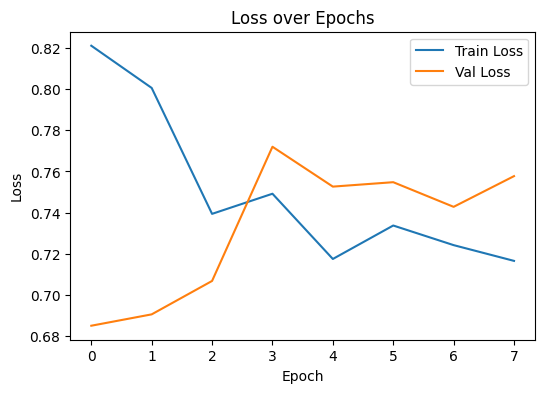

Test Accuracy: 55.00%


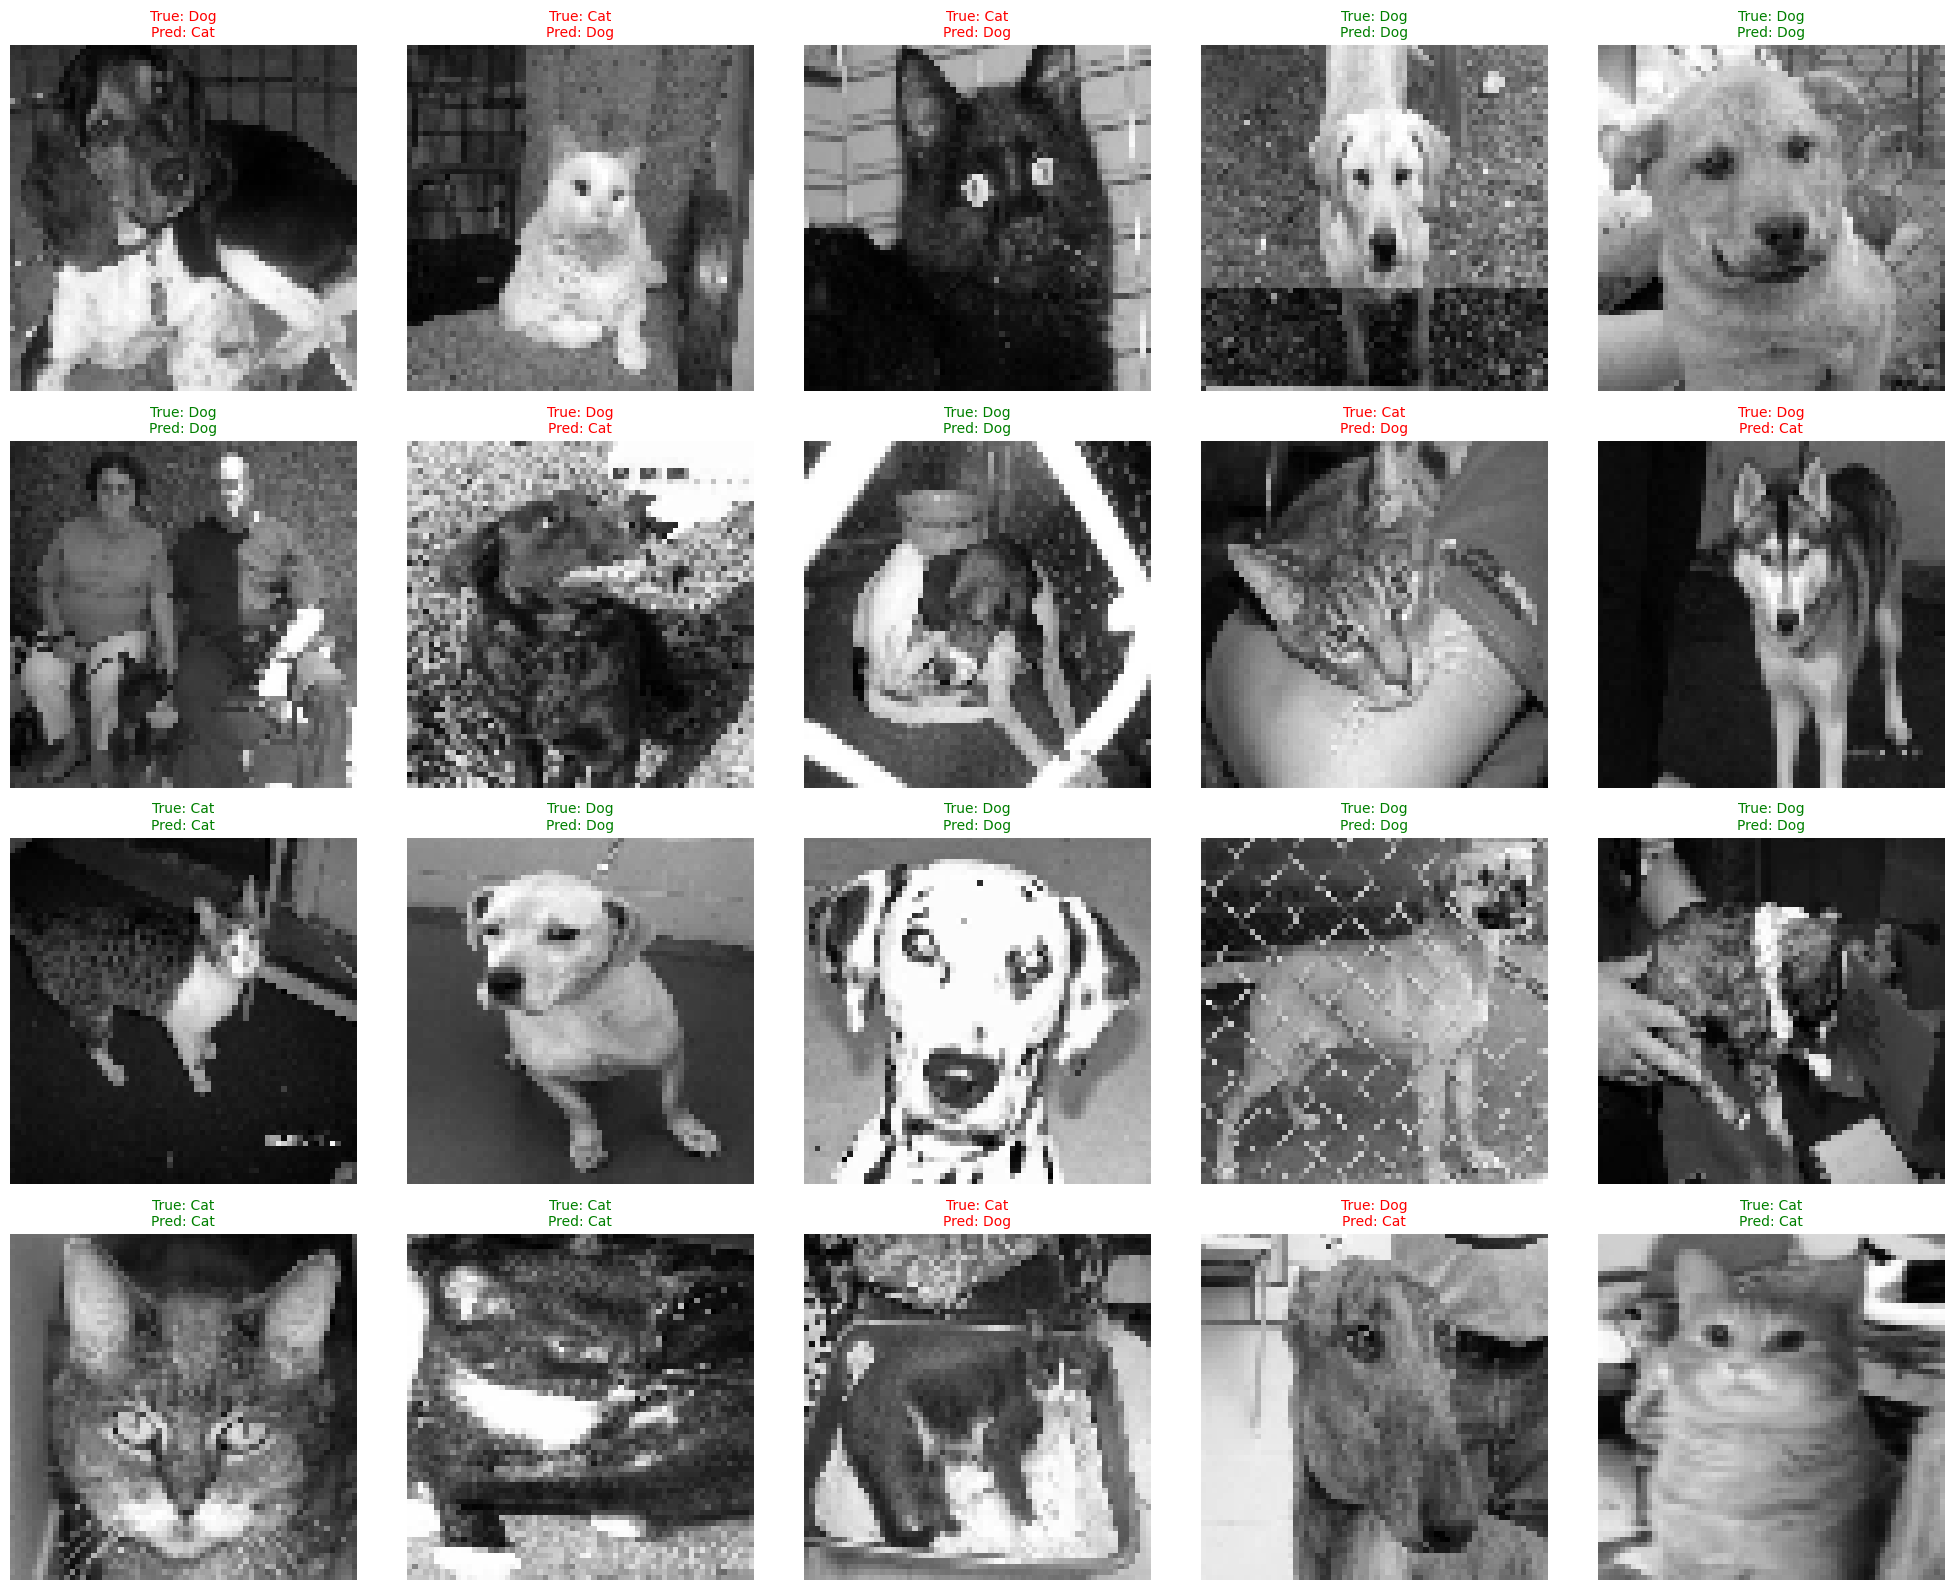

In [28]:
# =======================================
# 9. Retrain Best Model on Train + Val and Evaluate on Test
# =======================================
best_params = trial.params
n_conv_layers = best_params["n_conv_layers"]
conv_layers = []
for i in range(n_conv_layers):
    filters = best_params[f"conv_filters_l{i}"]
    kernel_size = best_params[f"conv_kernel_size_l{i}"]
    conv_layers.append((filters, kernel_size))
n_dense_layers = best_params["n_dense_layers"]
dense_layers = [best_params[f"n_units_l{i}"] for i in range(n_dense_layers)]
lr = best_params["lr"]
batch_size = best_params["batch_size"]
dropout_rates = [best_params[f"dropout_l{i}"] for i in range(n_dense_layers)]
weight_decay = best_params["weight_decay"]
stopping_patience = best_params["stopping_patience"]
# activations = [best_params[f"activation_l{i}"] for i in range(n_dense_layers)]
# activations = [best_params["activation"]] * n_dense_layers
step_size = best_params["step_size"]
gamma = best_params["gamma"]

config = TrainConfig(
    conv_layers=conv_layers, 
    dense_layers=dense_layers,
    activations=None, 
    dropout_rates=dropout_rates, 
    loss_function=loss_function, 
    lr=lr, 
    batch_size=batch_size, 
    epochs=epochs*2, 
    weight_decay=weight_decay, 
    step_size=step_size, 
    gamma=gamma,
    early_stopping=True, 
    patience=stopping_patience, 
    use_amp=True
    )

# Retrain final model
best_model, history = train_model(
    X_train, 
    y_train,
    X_test, 
    y_test,
    output_dim,
    config,
    plot_loss=True
)

# Evaluate on test set
y_pred_test, _ = predict_tf(best_model, X_test, y_test, batch_size=batch_size)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Test Accuracy: {test_accuracy:.2f}%")
plot_images(X_test, y_test, y_pred_test, num_images=20)